# Модель для «Мегалайна»

Цель проекта — построить модель для задачи классификации с максимальной `accuracy` не ниже 0,75, которая по информации о поведении пользователя за месяц (числу и длительности звонков, числу СМС и Мб трафика) подберет ему подходящий тариф «Смарт» или «Ультра».

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-исходных-данных" data-toc-modified-id="Загрузка-исходных-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка исходных данных</a></span></li><li><span><a href="#Подготовка-к-моделированию" data-toc-modified-id="Подготовка-к-моделированию-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка к моделированию</a></span></li><li><span><a href="#Моделирование" data-toc-modified-id="Моделирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Моделирование</a></span><ul class="toc-item"><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#CatBoost-как-бенчмарк" data-toc-modified-id="CatBoost-как-бенчмарк-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoost как бенчмарк</a></span></li></ul></li><li><span><a href="#Выбор-лучшей-модели" data-toc-modified-id="Выбор-лучшей-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выбор лучшей модели</a></span></li><li><span><a href="#Dummy-тест" data-toc-modified-id="Dummy-тест-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Dummy-тест</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Загрузка исходных данных

Подключим необходимые модули и зафиксируем `random_state`.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from time import time

rs = 22221111 # кастомный random_state, использующийся в проекте

Загрузим данные и взглянем на них.

In [2]:
df = pd.read_csv("/datasets/users_behavior.csv")

In [3]:
display(df)
df.info()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Пропусков нет. Все фичи сохранены как `float64`, а бинарный таргет как `int64`. Но звонки и СМС целые по природе, а знаки после запятой у минут и Мб вряд ли будут полезными для модели. Сэкономим память и повысим скорость обработки датасета, округлив минуты и Мб и приведя все столбцы к минимальному беззнаковому целочисленному типу. 

In [4]:
df = df.round().apply(pd.to_numeric, downcast='unsigned')

In [5]:
display(df)
df.info()

,calls,minutes,messages,mb_used,is_ultra
0,40,312,83,19915,0
1,85,517,56,22697,0
2,77,468,86,21060,0
3,106,746,81,8437,1
4,66,419,1,14503,0
...,...,...,...,...,...
3209,122,911,20,35125,1
3210,25,190,0,3276,0
3211,97,634,70,13974,0
3212,64,462,90,31240,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   calls     3214 non-null   uint8 
 1   minutes   3214 non-null   uint16
 2   messages  3214 non-null   uint8 
 3   mb_used   3214 non-null   uint16
 4   is_ultra  3214 non-null   uint8 
dtypes: uint16(2), uint8(3)
memory usage: 22.1 KB


Другое дело :) Проверим, не появились ли полные дубли после округления.

In [6]:
df.duplicated().sum()

0

Не появились — приступаем к подготовке данных для моделирования.

## Подготовка к моделированию

Разделим датасет на обучающую, валидационную и тестовую выборки в каноничной пропорции 3:1:1.

In [7]:
(df_train, df_valid_test) = train_test_split(df, test_size=.4, random_state=rs)
(df_valid, df_test) = train_test_split(df_valid_test, test_size=.5, random_state=rs)

In [8]:
print(df_train.shape)
print(df_valid.shape)
print(df_test.shape)

(1928, 5)
(643, 5)
(643, 5)


Разделим каждую выборку на фичи и таргет.

In [9]:
x_train = df_train.drop(columns='is_ultra') # фичи
x_valid = df_valid.drop(columns='is_ultra')
x_test = df_test.drop(columns='is_ultra')

y_train = df_train['is_ultra'] # таргет
y_valid = df_valid['is_ultra']
y_test = df_test['is_ultra']

## Моделирование

### Дерево решений

Обучим семейство деревьев решений на обучающей выборке, перебирая их максимальную глубину, и выберем дерево с максимальной метрикой `accuracy` на валидационной выборке.

In [10]:
max_d_max = 15 # максимальное из перебираемых значений max_depth 

best_score = 0
scores = [] # сюда будем сохранять accuracy каждой модели, чтобы потом нарисовать график 
times = [] # а сюда — время обучения моделей

for max_d in range(1, max_d_max + 1): # перебираем максимальную глубину дерева
    model = DecisionTreeClassifier(random_state=rs, max_depth=max_d)
    start_time = time()
    model.fit(x_train, y_train) # обучаем на обучающей
    t = time() - start_time 
    times.append(t)
    score = model.score(x_valid, y_valid) # тестируем на валидационной
    scores.append(score)
    if score > best_score:
        best_score = score
        best_time = t
        tree = model

best_score, best_time, tree

(0.7900466562986003,
 0.0055561065673828125,
 DecisionTreeClassifier(max_depth=4, random_state=22221111))

Посмотрим на графики.

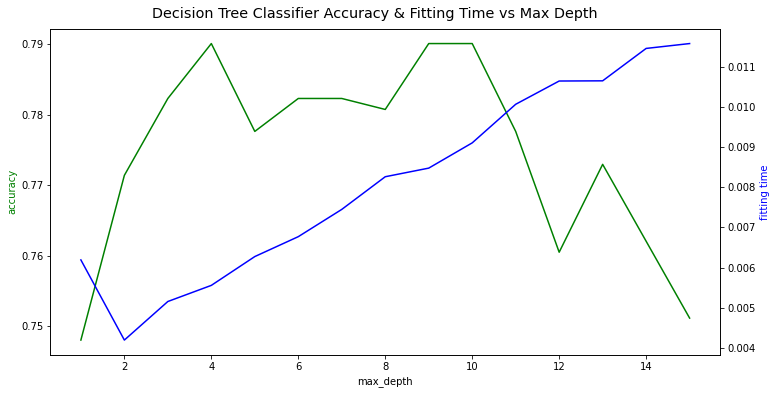

In [11]:
fig, ax1 = plt.subplots(figsize=(12, 6));
fig.suptitle('Decision Tree Classifier Accuracy & Fitting Time vs Max Depth', 
             fontsize='x-large', y=.93);

ax2 = ax1.twinx();
ax1.plot(range(1, max_d_max + 1), scores, 'g-');
ax2.plot(range(1, max_d_max + 1), times, 'b-');

ax1.set_xlabel('max_depth');
ax1.set_ylabel('accuracy', color='g');
ax2.set_ylabel('fitting time', color='b');

Метрика `accuracy` модели на валидационной выборке растет при увеличении `max_depth` с 1 до 4, незначительно изменяется при последующем увеличении до 10 и падает при дальнейшем увеличении. Время обучения, ожидаемо, растет с увеличением `max_depth`. Лучшее дерево имеет максимальную глубину 4 и `accuracy` 0,79 на валидационной выборке.

### Случайный лес

Повторим то же упражнение для случайного леса с перебором максимальной глубины и числа деревьев.

In [12]:
max_d_max = 15 # максимальное из перебираемых значений max_depth 
n_est_max = 30 # максимальное из перебираемых значений n_estimators 

best_score = 0
scores = [] # сюда будем сохранять accuracy каждой модели, чтобы потом нарисовать график
times = [] # а сюда — время обучения моделей

for n_est in range(1, n_est_max + 1): # перебираем число деревьев
    for max_d in range(1, max_d_max + 1): # и их максимальную глубину
        model = RandomForestClassifier(random_state=rs, max_depth=max_d, 
                                       n_estimators=n_est)
        start_time = time()
        model.fit(x_train, y_train) # обучаем на обучающей
        t = time() - start_time 
        times.append(t)
        score = model.score(x_valid, y_valid) # тестируем на валидационной
        scores.append(score)
        if score > best_score:
            best_score = score
            best_time = t
            forest = model

best_score, best_time, forest

(0.8102643856920684,
 0.06439900398254395,
 RandomForestClassifier(max_depth=8, n_estimators=17, random_state=22221111))

Построим тепловую карту для `accuracy`...

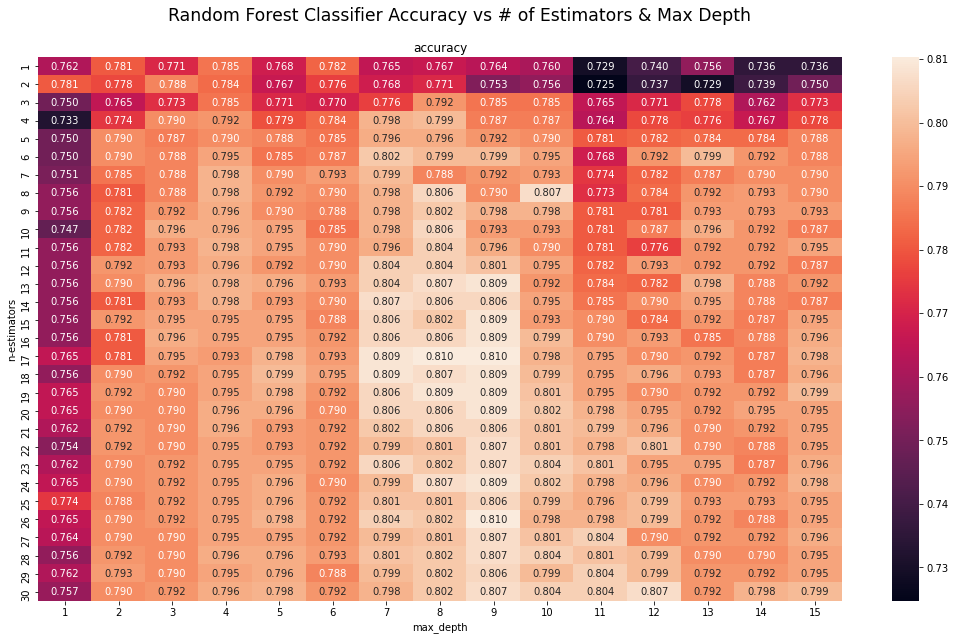

In [13]:
plt.figure(figsize=(18, 10));
plt.suptitle('Random Forest Classifier Accuracy vs # of Estimators & Max Depth', 
             fontsize='xx-large', x=.45, y=.95);

ax = sns.heatmap(
    np.array(scores).reshape(n_est_max, max_d_max), # превращаем список в матрицу
    xticklabels=range(1, max_d_max + 1), 
    yticklabels=range(1, n_est_max + 1),
    annot=True,
    fmt=".3f"
);
ax.set(title='accuracy',
       xlabel='max_depth',
       ylabel='n-estimators'
);

...и для времени обучения.

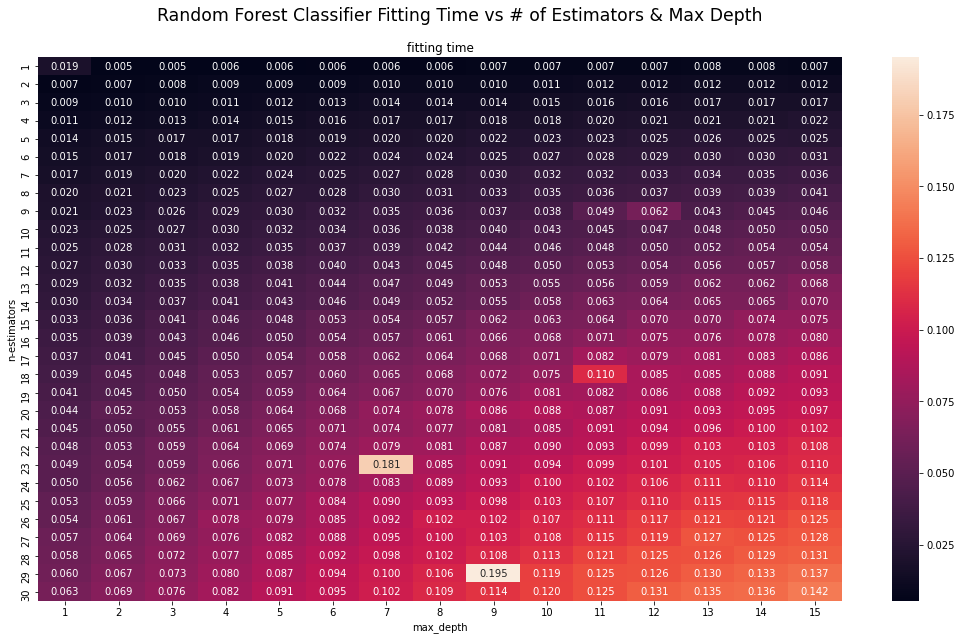

In [14]:
plt.figure(figsize=(18, 10));
plt.suptitle('Random Forest Classifier Fitting Time vs # of Estimators & Max Depth', 
             fontsize='xx-large', x=.45, y=.95);

ax = sns.heatmap(
    np.array(times).reshape(n_est_max, max_d_max), # превращаем список в матрицу
    xticklabels=range(1, max_d_max + 1), 
    yticklabels=range(1, n_est_max + 1),
    annot=True,
    fmt=".3f"
);
ax.set(title='fitting time',
       xlabel='max_depth',
       ylabel='n-estimators'
);

Метрика `accuracy` модели на валидационной выборке наиболее высока при числе деревьев от 13 до 24 и максимальной глубине дерева от 7 до 9. Время обучения растет при увеличении как числа деревьев, так и их максимальной глубины.

Лучший лес состоит из 17 деревьев с максимальной глубиной 8, имеет `accuracy` 0,81 на валидационной выборке — чуть лучше, чем у одного дерева — и обучается на порядок дольше его. 

### Логистическая регрессия

Теперь обучим модель логистической регрессии, но перебирать в ней ничего не будем.

In [15]:
logit = LogisticRegression(random_state=rs, max_iter=1000)
start_time = time()
logit.fit(x_train, y_train) # обучаем на обучающей
best_time = time() - start_time
best_score = logit.score(x_valid, y_valid) # тестируем на валидационной

best_score, best_time, logit

(0.7589424572317263,
 0.07157111167907715,
 LogisticRegression(max_iter=1000, random_state=22221111))

Получили худшую `accuracy` из обученных моделей — 0,76. Зато относительно быстро.

### CatBoost как бенчмарк

Наконец, в качестве бенчмарка обучим модель `CatBoost`.

In [16]:
cat = CatBoostClassifier(random_state=rs, silent=True)
start_time = time()
cat.fit(x_train, y_train) # обучаем на обучающей
best_time = time() - start_time
best_score = cat.score(x_valid, y_valid) # тестируем на валидационной 

best_score, best_time, cat

(0.7884914463452566,
 3.090709924697876,
 <catboost.core.CatBoostClassifier at 0x7f1cc8c095e0>)

На валидационной выборке бенчмарк проявил себя не лучшим образом, показав вторую `accuracy` с конца — 0,79 — и худшее с большим отрывом время обучения.

Посмотрим, какие результаты покажут наши модели на тестовой выборке.

## Выбор лучшей модели

Сравним `accuracy` всех четырех моделей на валидационной и тестовой выборках.

In [17]:
pd.DataFrame([[tree.score(x_valid, y_valid), tree.score(x_test, y_test)],
              [forest.score(x_valid, y_valid), forest.score(x_test, y_test)],
              [logit.score(x_valid, y_valid), logit.score(x_test, y_test)],
              [cat.score(x_valid, y_valid), cat.score(x_test, y_test)]],
             columns=['valid', 'test'],
             index=['tree', 'forest', 'logit', 'cat']).round(3)

,valid,test
tree,0.790,0.768
forest,0.810,0.788
logit,0.759,0.733
cat,0.788,0.802


На тестовой выборке модель `CatBoost` показывает лучший результат, обгоняя случайный лес. Т.к. бенчмарк вне конкурса, то побеждает модель случайного леса с 17 деревьями и максимальной глубиной 8.

## Dummy-тест

Перед отправкой леса в продакшн проверим его вместе с остальными моделями на адекватность. Для этого посчитаем `accuracy` на тестовой выборке двух dummy-моделей, одна из которых выдает случайный результат с учетом частотности классов в обучающей выборке, а другая просто всегда выдает превалирующий класс 0 (тариф Smart).

In [18]:
np.random.seed(rs) # инициализируем генератор псевдослучайных чисел

# генерим столбец случайных предсказаний для тестовой выборки,
# в котором доля тарифа Ultra примерно такая же, как в обучающей выборке
y_dummy1 = np.random.binomial(1, y_train.mean(), len(y_test))

# генерим столбец нулевых предсказаний для тестовой выборки
y_dummy2 = [0] * len(y_test)

# считаем accuracy dummy-предсказаний на тестовой выборке
print(accuracy_score(y_test, y_dummy1))
print(accuracy_score(y_test, y_dummy2))

0.5769828926905132
0.6671850699844479


Метрика `accuracy` у обеих dummy-моделей получилась заметно ниже, чем у любой из обученных моделей. Значит, все модели не бесполезные, и время на их обучение потрачено не зря.

Однако довольно высокое значение `accuracy` у второй dummy-модели говорит о том, что метрика для оценки моделей выбрана неудачно. Причина тому — дисбаланс классов в исходном датасете. Но это тема следующего спринта, поэтому не будем забегать вперед :)

## Выводы

- Из трех моделей: дерево решений, случайный лес и логистическая регрессия — наибольшее значение метрики `accuracy` на тестовой выборке — 0,79 — показал случайный лес из 17 деревьев максимальной глубины 8
- Из-за дисбаланса классов в исходном датасете метрика `accuracy` не лучший выбор для сравнения моделей в этом проекте 